In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from astropy import modeling
set_matplotlib_formats('retina')

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, balanced_accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import sklearn 
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from scipy import stats
import warnings
warnings.filterwarnings(action='ignore')

from inspect import signature

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import  TensorDataset, DataLoader
from torchvision.utils import save_image
import os
from os import listdir
from os.path import isfile, join

import seaborn as sns
import re

import warnings
warnings.filterwarnings(action='ignore')

pd.options.display.float_format = '{:.2f}'.format

#from sklearn.metrics import mean_squared_error, precision_score
from contrast import small_model
from contrast import small_encoder, added_on_model, parse_option
from losses import SupConLoss
random_state = 42


In [ ]:
# data=pd.read_csv("./data_1004.csv")
data=pd.read_csv("./data1201.csv")

columns = data.iloc[:,2:-19].columns
columns =columns.drop(['pleura_tb', 'pleura_bac','blood_positive', 'blood_obscure', 'cancer'])
float_column=data[columns].select_dtypes(include=['float']).columns
object_column = data[columns].select_dtypes(include=['object']).columns
not_object = ['D-dimer', 'BNP', 'procalcitonin', 'ANA titer','ANA 1:40','ionized calcium','E-ANC_blood']

data[not_object[0]] = data[not_object[0]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[1]] = data[not_object[1]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[2]] = data[not_object[2]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[5]] = data[not_object[5]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)

def floating(x):
    try:
        value = float(x)
    except ValueError :
        value = np.nan
    return value

data[not_object[6]] = data[not_object[6]].replace("\-","",regex=True).apply(floating).astype(float)
data[not_object[4]] = data[not_object[4]].replace({np.nan:0, 
  'Neg(<1:40)':0,
  'Non(<1:40)':0,
  'Pos. Speckled':1,
  'Reactive Speckled':2,
  'Cytoplasmic':3,
  'Reactive Nuclear membrane':4,
  'Positive Speckled':5})

data[not_object[3]] =  data[not_object[3]].replace({np.nan:0,
 '<1:40':0,
 'Speckled 1:1280':1,
 'Speckled 1:40':2,
 'Nucleolar 1:80':3,
 'Homogene.1:640':4,
 'Mixed type(Remark)':5,
 'Nucle.Membrane 1:80':6,
 'Speckled 1:160':7,
 'Homogene.1:40':8,
 'Nucleolar 1:640':9,
 'Homogene.1:160':10,
 'Discr.speckled 1:1280':11,
 'Nucleolar 1:40':12,
 'Homogene.1:80':13,
 'Homogene.1:1280':14,
 'Speckled 1:320':15})

data[['ANA1','ANA2','ANA3','ANA4','ANA5','ANA6','ANA7','ANA8','ANA9','ANA10','ANA11','ANA12','ANA13','ANA14',
    'ANA15','ANA16']]=pd.DataFrame(np.eye(len(data[not_object[3]].unique()))[data[not_object[3]]])

data[['ANA_1','ANA_2','ANA_3','ANA_4','ANA_5','ANA_6']]=pd.DataFrame(np.eye(len(data[not_object[4]].unique()))[data[not_object[4]]])

reallist = float_column.tolist()+['D-dimer', 'BNP', 'procalcitonin','ionized calcium','E-ANC_blood']
analist = ['ANA1','ANA2','ANA3','ANA4','ANA5','ANA6','ANA7','ANA8','ANA9','ANA10','ANA11','ANA12','ANA13','ANA14',
    'ANA15','ANA16','ANA_1','ANA_2','ANA_3','ANA_4','ANA_5','ANA_6']

data.loc[data['ph_pleural fluid'].isna(), 'ph_pleural fluid'] = data.loc[data['ph_pleural fluid'].isna(), 'pH_pleural fluid(Qn) ']

list_04 = ['ADA_pleural fluid', 'LD_pleural fluid', 'albumin_pleural fluid', 'ph_pleural fluid', 'Total protein_pleural fluid', 'Glucose_pleural fluid',
 'Total amylase_pleural fluid', 'Creatinine', 'AST(SGOT)', 'Alkaline phosphatase', 'total bilirubin', 'glucose', 'Albumin', 'BUN',
'Total protein', 'LD', 'ALT(SGPT)', 'r-GT', 'CRP', 'D-dimer', 'BNP', 'procalcitonin', 'total calcium', 'sodium', 'chloride', 'potassium', 'phosphorus', 'Hb_blood',
'RDW_blood', 'WBC_blood', 'MCHC_blood', 'MCV_blood', 'PDW_blood', 'Hct_blood', 'E-ANC_blood', 'MCH_blood', 'RBC_blood', 'MPV_blood', 'Platelet_blood', "Histiocyte (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid", "RBC (Qn)[Cytospin,Wright's stain],Pleural fluid", "Eosinophil (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Nucleated cells (Qn)[Cytospin,Wright's stain],Pleural fluid", "Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid", "Mesothelial cell (Qn)[Cytospin,Wright's stain],Pleural fluid"
          ]


# 실제 데이터중 20%이상의 결손이 있는것을 빼면 다음과 같습니다.

xlist =dict()

for i in range(len(list_04)):
    xlist.update({data[list_04[i]].name: stats.mode(data[list_04[i]]).mode.item()})

for i in range(len(list_04)):
    data[list_04[i]] = data[list_04[i]].replace(np.nan, xlist[list_04[i]])

data.loc[data['pleura_bac']>0,'Labeling']=3

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_label']="bacterial"
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_label']="tuberculosis"
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_label']="malignancy"
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_label']="volume"
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_label']="other"

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_int']=0
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_int']=1
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_int']=2
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_int']=3
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_int']=4
data.loc[((data['new_int'].isna())& (data['제외']!=1))
         ,'new_int']=4

data['LD_ratio'] = data['LD_pleural fluid']/data['LD']>=0.6
data['LD_raw'] = data['LD_pleural fluid']>= 250*2/3
data['PF_ratio'] = data['Total protein_pleural fluid']/data['Total protein']>=0.6


data['sum_pleural'] = data['LD_ratio'].replace(True, 1).replace(False,0) +data['LD_raw'].replace(True, 1).replace(False,0)+data['PF_ratio'].replace(True, 1).replace(False,0)

data['exudate']= data['sum_pleural']>=1

#previous rule for empyema

data['low_pH']=data['ph_pleural fluid']<7.2
data['low_glu']=data['Glucose_pleural fluid']<61
data['high_LDH']=data['LD_pleural fluid']>1000
data['score']=data['low_pH'].replace(True, 1).replace(False,0)+data['low_glu'].replace(True, 1).replace(False,0)+data['high_LDH'].replace(True, 1).replace(False,0)
data['complicated_pleural_effusion']=data['score']>2

data = data.loc[data['제외']!=1]

training = data[list_04+['new_label']+['new_int']]
training_only = training.loc[training['new_label'].isna()==False]
col_name  = training.columns.difference(["new_label",'new_int'])


range_lower = 0.05
range_upper = 0.95
outcome_quantile = training[col_name].quantile([range_lower, range_upper])

for i in col_name:
    training.loc[(training[i]<=outcome_quantile[i][range_lower]),i]=\
        outcome_quantile[i][range_lower]

    training.loc[(training[i]>=outcome_quantile[i][range_upper]),i]=\
        outcome_quantile[i][range_upper]

label_name = data.loc[(data['new_label'].isna()==False)&
                      (data['new_label']!=7), 'new_label'].unique()

#label붙은것만 뽑기
training = training.loc[training['new_label'].isna()==False]

columns15=['ADA_pleural fluid','LD_pleural fluid','albumin_pleural fluid',
'AST(SGOT)','Alkaline phosphatase',
'Alkaline phosphatase','Albumin','Total protein','ALT(SGPT)',
'total calcium','Hb_blood','RDW_blood','WBC_blood',
'MCV_blood','Hct_blood','RBC_blood','Platelet_blood',"Histiocyte (Qn)[Cytospin,Wright's stain],Pleural fluid","Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Eosinophil (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid","Mesothelial cell (Qn)[Cytospin,Wright's stain],Pleural fluid"]

In [ ]:
scaler01 = MinMaxScaler(feature_range=(0.01,1))
scaler01 = scaler01.fit(training[col_name])
training[col_name] = scaler01.transform(training[col_name])

In [ ]:
# Device configuration
X_train, X_notrain, y_train, y_nottrain = train_test_split(training[col_name],
                                                    training['new_int'], test_size = 0.3
                                                    , random_state = 52
                                                   )
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train = X_train.rename(columns = lambda x:re.sub('\_', '', x))

X_notrain = X_notrain.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_notrain = X_notrain.rename(columns = lambda x:re.sub('\_', '', x))


### extravalidation

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

pd.options.display.float_format = '{:.2f}'.format

# eval_data=pd.read_csv("./eval_data_1004.csv")
# eval_data=pd.read_csv("./eval_data1201.csv")
eval_data=pd.read_csv("./data2100205.csv")

columns = eval_data.iloc[:,2:-19].columns
columns =columns.drop(['pleura_tb', 'pleura_bac','blood_positive', 'blood_obscure', 'cancer'])
float_column=eval_data[columns].select_dtypes(include=['float']).columns
object_column = eval_data[columns].select_dtypes(include=['object']).columns
not_object = ['D-dimer', 'BNP', 'procalcitonin', 'ANA titer','ANA 1:40','ionized calcium','E-ANC_blood']

eval_data[not_object[0]] = eval_data[not_object[0]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
eval_data[not_object[1]] = eval_data[not_object[1]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
eval_data[not_object[2]] = eval_data[not_object[2]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
eval_data[not_object[5]] = eval_data[not_object[5]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)

def floating(x):
    try:
        value = float(x)
    except ValueError :
        value = np.nan
    return value

eval_data[not_object[6]] = eval_data[not_object[6]].replace("\-","",regex=True).apply(floating).astype(float)


reallist = float_column.tolist()+['D-dimer', 'BNP', 'procalcitonin','ionized calcium','E-ANC_blood']


eval_data.loc[eval_data['ph_pleural fluid'].isna(), 'ph_pleural fluid'] = eval_data.loc[eval_data['ph_pleural fluid'].isna(), 'pH_pleural fluid(Qn) ']
count_label = pd.DataFrame(eval_data.count()/len(eval_data))

list_04 = ['ADA_pleural fluid', 'LD_pleural fluid', 'albumin_pleural fluid', 'ph_pleural fluid', 'Total protein_pleural fluid', 'Glucose_pleural fluid',
'Total amylase_pleural fluid', 'Creatinine', 'AST(SGOT)', 'Alkaline phosphatase', 'total bilirubin', 'glucose', 'Albumin', 'BUN',
'Total protein', 'LD', 'ALT(SGPT)', 'r-GT', 'CRP', 'D-dimer', 'BNP', 'procalcitonin', 'total calcium', 'sodium', 'chloride', 'potassium', 'phosphorus', 'Hb_blood',
'RDW_blood', 'WBC_blood', 'MCHC_blood', 'MCV_blood', 'PDW_blood', 'Hct_blood', 'E-ANC_blood', 'MCH_blood', 'RBC_blood', 'MPV_blood', 'Platelet_blood', "Histiocyte (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid", "RBC (Qn)[Cytospin,Wright's stain],Pleural fluid", "Eosinophil (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Nucleated cells (Qn)[Cytospin,Wright's stain],Pleural fluid", "Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid", "Mesothelial cell (Qn)[Cytospin,Wright's stain],Pleural fluid"
          ]

xlist =dict()

for i in range(len(list_04)):
    xlist.update({eval_data[list_04[i]].name: stats.mode(eval_data[list_04[i]]).mode.item()})

for i in range(len(list_04)):
    eval_data[list_04[i]] = eval_data[list_04[i]].replace(np.nan, xlist[list_04[i]])

eval_data.loc[eval_data['pleura_bac']>0,'Labeling']=3

eval_data.loc[((eval_data['Labeling'].isin([3,17,"3","17"]))& (eval_data['제외']!=1)),'new_label']="bacterial"
eval_data.loc[((eval_data['Labeling'].isin([1,"1"]))& (eval_data['제외']!=1)),'new_label']="tuberculosis"
eval_data.loc[((eval_data['Labeling'].isin([2,"2"]))& (eval_data['제외']!=1)),'new_label']="malignancy"
eval_data.loc[((eval_data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (eval_data['제외']!=1)),'new_label']="volume"
eval_data.loc[((eval_data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (eval_data['제외']!=1)),'new_label']="other"
eval_data.loc[((eval_data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (eval_data['제외']!=1)),'new_label']="other"
eval_data.loc[((eval_data['Labeling'].isin([9,15,"9","15"]))& (eval_data['제외']!=1))
         ,'new_label']="other"

eval_data.loc[((eval_data['Labeling'].isin([3,17,"3","17"]))& (eval_data['제외']!=1)),'new_int']=0
eval_data.loc[((eval_data['Labeling'].isin([1,"1"]))& (eval_data['제외']!=1)),'new_int']=1
eval_data.loc[((eval_data['Labeling'].isin([2,"2"]))& (eval_data['제외']!=1)),'new_int']=2
eval_data.loc[((eval_data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (eval_data['제외']!=1)),'new_int']=3
eval_data.loc[((eval_data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (eval_data['제외']!=1)),'new_int']=4
eval_data.loc[((eval_data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (eval_data['제외']!=1)),'new_int']=4
eval_data.loc[((eval_data['Labeling'].isin([9,15,"9","15"]))& (eval_data['제외']!=1))
         ,'new_int']=4
eval_data.loc[((eval_data['new_int'].isna())& (eval_data['제외']!=1))
         ,'new_int']=4

### test set process

eval_data.loc[((eval_data['final'].isin([3,17,"3","17"]))& (eval_data['제외']!=1)),'final_label']="bacterial"
eval_data.loc[((eval_data['final'].isin([1,"1"]))& (eval_data['제외']!=1)),'final_label']="tuberculosis"
eval_data.loc[((eval_data['final'].isin([2,"2"]))& (eval_data['제외']!=1)),'final_label']="malignancy"
eval_data.loc[((eval_data['final'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (eval_data['제외']!=1)),'final_label']="volume"
eval_data.loc[((eval_data['final'].isin([7,10,14,19,25,29,30,35,36,"7","10","14","19","25","29","30","35","36"]))
          & (eval_data['제외']!=1)),'final_label']="other"
eval_data.loc[((eval_data['final'].isin([8,16,24,23,20,21,27,28,31,32,"8","16","24","23","20","21","27","28","31","32"]))
          & (eval_data['제외']!=1)),'final_label']="other"
eval_data.loc[((eval_data['final'].isin([9,15,33,34,"9","15","33","34"]))& (eval_data['제외']!=1))
         ,'final_label']="other"

eval_data.loc[((eval_data['final'].isin([3,17,"3","17"]))& (eval_data['제외']!=1)),'final_int']=0
eval_data.loc[((eval_data['final'].isin([1,"1"]))& (eval_data['제외']!=1)),'final_int']=1
eval_data.loc[((eval_data['final'].isin([2,"2"]))& (eval_data['제외']!=1)),'final_int']=2
eval_data.loc[((eval_data['final'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (eval_data['제외']!=1)),'final_int']=3
eval_data.loc[((eval_data['final'].isin([7,10,14,19,25,29,30,35,36,"7","10","14","19","25","29","30","35","36"]))
          & (eval_data['제외']!=1)),'final_int']=4
eval_data.loc[((eval_data['final'].isin([8,16,24,23,20,21,27,28,31,32,"8","16","24","23","20","21","27","28","31","32"]))
          & (eval_data['제외']!=1)),'final_int']=4
eval_data.loc[((eval_data['final'].isin([9,15,33,34,"9","15","33","34"]))& (eval_data['제외']!=1))
         ,'final_int']=4

eval_data['LD_ratio'] = eval_data['LD_pleural fluid']/eval_data['LD']>=0.6
eval_data['LD_raw'] = eval_data['LD_pleural fluid']>= 250*2/3
eval_data['PF_ratio'] = eval_data['Total protein_pleural fluid']/eval_data['Total protein']>=0.6


eval_data['sum_pleural'] = eval_data['LD_ratio'].replace(True, 1).replace(False,0) +eval_data['LD_raw'].replace(True, 1).replace(False,0)+eval_data['PF_ratio'].replace(True, 1).replace(False,0)

eval_data['exudate']= eval_data['sum_pleural']>=1


eval_data['low_pH']=eval_data['ph_pleural fluid']<7.2
eval_data['low_glu']=eval_data['Glucose_pleural fluid']<61
eval_data['high_LDH']=eval_data['LD_pleural fluid']>1000

eval_data['score']=eval_data['low_pH'].replace(True, 1).replace(False,0)+eval_data['low_glu'].replace(True, 1).replace(False,0)+eval_data['high_LDH'].replace(True, 1).replace(False,0)

eval_data['complicated_pleural_effusion']=eval_data['score']>2
eval_data['might_Tb']= eval_data['ADA_pleural fluid']>50
eval_data['lymph_dominant'] = eval_data["Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid"]/eval_data["Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid"]>0.75
eval_data.loc[(eval_data['lymph_dominant']==True) & (eval_data['might_Tb']==True),'Tuberculosis']=1

In [ ]:
eval_data['trans_label']=eval_data['final_label']
eval_data.loc[eval_data['Tuberculosis']==True,'trans_label']='suggest_tuberculosis'
eval_data.loc[(eval_data['Tuberculosis']==True)&
         (eval_data['final_label']!='tuberculosis'),'trans_label']='not_tuberculosis'
eval_data['trans_int']=eval_data['final_int']
eval_data.loc[eval_data['Tuberculosis']==True,'trans_int']=5
eval_data.loc[(eval_data['Tuberculosis']==True)&
         (eval_data['final_label']!='tuberculosis'),'trans_int']=7
eval_data['trans_label2']=eval_data['final_label']
eval_data.loc[eval_data['complicated_pleural_effusion']==True,'trans_label2']='suggest_complicated_effusion'
eval_data.loc[(eval_data['complicated_pleural_effusion']==True)&
         (eval_data['final_label']!='bacterial'),'trans_label2']='not_bacteria'
eval_data['trans_int2']=eval_data['final_int']
eval_data.loc[eval_data['complicated_pleural_effusion']==True,'trans_int2']=6
eval_data.loc[(eval_data['complicated_pleural_effusion']==True)&
         (eval_data['final_label']!='bacterial'),'trans_int2']=8

In [ ]:
eval_data = eval_data.loc[eval_data['제외']!=1]

training = eval_data[list_04+['new_label']+['new_int']]
training_only = training.loc[training['new_label'].isna()==False]
col_name  = training.columns.difference(["new_label",'new_int'])

range_lower = 0.05
range_upper = 0.95
outcome_quantile = training[col_name].quantile([range_lower, range_upper])

testset = eval_data.loc[eval_data['final_label'].isna()==False]

testset_only = testset[list_04+['final_label','final_int','trans_label','trans_int',
                               'trans_label2','trans_int2']]

for i in col_name:
    testset_only.loc[(testset_only[i]<=outcome_quantile[i][range_lower]),i]=\
        outcome_quantile[i][range_lower]

    testset_only.loc[(testset_only[i]>=outcome_quantile[i][range_upper]),i]=\
        outcome_quantile[i][range_upper]
    
scaler01 = MinMaxScaler(feature_range=(0.01,1))
scaler01 = scaler01.fit(testset_only[col_name])
testset_only[col_name] = scaler01.transform(testset_only[col_name])

In [ ]:
extra_X = testset_only[col_name]
extra_y = testset_only["final_int"]
torch_extra_X = torch.tensor(testset_only[col_name].to_numpy(), dtype= torch.float32)
torch_extra_Y = torch.tensor(testset_only["final_int"].to_numpy(), dtype= torch.float32)


### Model training
* multinomial logistic model
* random-forest model
* gradient-boost model

In [ ]:
mn_model = LR(multi_class = 'multinomial', solver = 'newton-cg',
           random_state = 0, class_weight=None, max_iter = 300).fit(X_train, y_train)

In [ ]:
lgbm_model = LGBMClassifier(boosting_type='gbdt', n_estimators=3000,
                        learning_rate=0.3, objective = 'multiclass',
                        metric = 'multi_logloss', min_split_gain=0.0,
                        class_weight="balanced", colsample_bytree=0.5,
                        random_state=0).fit(X_train, y_train)

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 1000,
                               max_features = 0.6,
                               class_weight = 'balanced',
                               criterion = 'entropy',
                               random_state=42, n_jobs=-1).fit(X_train,  y_train)

In [ ]:
mn_proba = mn_model.predict_proba(X_notrain)
lgbm_proba = lgbm_model.predict_proba(X_notrain)
rf_proba = rf_model.predict_proba(X_notrain)

In [ ]:
nnet_model = torch.load('./simple_model_0502/model_[1024, 1024, 1024, 20]_670.pt')
nnet_model = nnet_model.cuda()
nnet_model.eval()
pre_last, nnet_p_label = nnet_model(torch.tensor(np.array(X_notrain), dtype=torch.float32).cuda())


In [ ]:
opt = parse_option()
opt.model_path = './save/{}_{}_models'.format("effu0502_weighted", 20)
loaded_model = torch.load(opt.model_path+"/model_[128, 256, 128, 32]_loss_6.250.pth")

sup_model = small_encoder(46, [128, 256, 128, 32], 20)
sup_model.load_state_dict(loaded_model["model"])
sup_model = sup_model.cuda()
sup_model = sup_model.eval()

classifier_model =  torch.load('./model_classifier0502/model_[128, 5]_582.pt')
#classifier_model =  torch.load('./model_classifier0502/model_[5]_1102.pt')

classifier_model = classifier_model.eval()
sup_label = classifier_model(torch.tensor(np.array(X_notrain), dtype=torch.float32).cuda())
sup_predict = torch.argmax(sup_label, axis=1)

In [ ]:
from util import accuracy
mn1, mn2 = accuracy(torch.tensor(mn_model.predict_proba(X_notrain)), torch.tensor(y_nottrain.values), topk=(1, 2))
lgbm1, lgbm2 = accuracy(torch.tensor(lgbm_model.predict_proba(X_notrain)), torch.tensor(y_nottrain.values), topk=(1, 2))
rf1, rf2 = accuracy(torch.tensor(rf_model.predict_proba(X_notrain)), torch.tensor(y_nottrain.values), topk=(1, 2))
nnet1, nnet2 = accuracy(nnet_p_label.cpu(), torch.tensor(y_nottrain.values), topk=(1, 2))
sup1, sup2 = accuracy(sup_label.cpu(), torch.tensor(y_nottrain.values), topk=(1, 2))

### Validation set
* Accuracy and AUROC

In [35]:
#accuracy
print(f"multinomial top-1, top-2 accuracy: {mn1.item():.2f}, {mn2.item():.2f}")
print(f"Randomforest top-1, top-2 accuracy: {rf1.item():.2f}, {rf2.item():.2f}")
print(f"LGBM top-1, top-2 accuracy: {lgbm1.item():.2f}, {lgbm2.item():.2f}")
print(f"NNET top-1, top-2 accuracy:{nnet1.item():.2f}, {nnet2.item():.2f}")
print(f"Sup top-1, top-2 accuracy:{sup1.item():.2f}, {sup2.item():.2f}")

multinomial top-1, top-2 accuracy: 80.45, 91.83
Randomforest top-1, top-2 accuracy: 80.94, 92.08
LGBM top-1, top-2 accuracy: 82.92, 91.83
NNET top-1, top-2 accuracy:79.46, 90.10
Sup top-1, top-2 accuracy:81.68, 90.35


In [36]:
one_y = nn.functional.one_hot(torch.tensor(y_nottrain.values, dtype=torch.long))
print(f"mn weighted AUROC {roc_auc_score(one_y, mn_proba,  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y, mn_proba,  multi_class= 'ovr', average = 'micro'):.3f}")
print(f"rf weighted AUROC {roc_auc_score(one_y, rf_proba,  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y, rf_proba,  multi_class= 'ovr', average = 'micro'):.3f}")
print(f"lgbm weighted AUROC {roc_auc_score(one_y, lgbm_proba,  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y, lgbm_proba,  multi_class= 'ovr', average = 'micro'):.3f}")
print(f"NNET weighted AUROC {roc_auc_score(one_y, nnet_p_label.cpu().detach().numpy(),  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y, nnet_p_label.cpu().detach().numpy(),  multi_class= 'ovr', average = 'micro'):.3f}")
print(f"SupContrast weighted AUROC {roc_auc_score(one_y, sup_label.cpu().detach().numpy(),  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y, sup_label.cpu().detach().numpy(),  multi_class= 'ovr', average = 'micro'):.3f}")


mn weighted AUROC 0.941 micro AUROC 0.961
rf weighted AUROC 0.940 micro AUROC 0.963
lgbm weighted AUROC 0.947 micro AUROC 0.966
NNET weighted AUROC 0.904 micro AUROC 0.935
SupContrast weighted AUROC 0.913 micro AUROC 0.942


In [37]:
mn_proba_extra = mn_model.predict_proba(extra_X)
lgbm_proba_extra = lgbm_model.predict_proba(extra_X)
rf_proba_extra = rf_model.predict_proba(extra_X)

In [38]:
pre_last, eval_nnet_label = nnet_model(torch.tensor(np.array(extra_X), dtype=torch.float32).cuda())
eval_sup_label = classifier_model(torch.tensor(np.array(extra_X), dtype=torch.float32).cuda())


### Extra-validation of all models
* Accuracy and AUROC

In [39]:
mn1_eval, mn2_eval = accuracy(torch.tensor(mn_model.predict_proba(extra_X)), torch.tensor(extra_y.values), topk=(1, 2))
lgbm1_eval, lgbm2_eval = accuracy(torch.tensor(lgbm_model.predict_proba(extra_X)), torch.tensor(extra_y.values), topk=(1, 2))
rf1_eval, rf2_eval = accuracy(torch.tensor(rf_model.predict_proba(extra_X)), torch.tensor(extra_y.values), topk=(1, 2))
nnet1_eval, nnet2_eval = accuracy(eval_nnet_label.cpu(), torch.tensor(extra_y.values), topk=(1, 2))
sup1_eval, sup2_eval = accuracy(eval_sup_label.cpu(), torch.tensor(extra_y.values), topk=(1, 2))

#accuracy
print(f"multinomial top-1, top-2 accuracy: {mn1_eval.item():.2f}, {mn2_eval.item():.2f}")
print(f"Randomforest top-1, top-2 accuracy: {rf1_eval.item():.2f}, {rf2_eval.item():.2f}")
print(f"LGBM top-1, top-2 accuracy: {lgbm1_eval.item():.2f}, {lgbm2_eval.item():.2f}")
print(f"NNET top-1, top-2 accuracy:{nnet1_eval.item():.2f}, {nnet2_eval.item():.2f}")
print(f"Sup top-1, top-2 accuracy:{sup1_eval.item():.2f}, {sup2_eval.item():.2f}")

multinomial top-1, top-2 accuracy: 60.63, 81.17
Randomforest top-1, top-2 accuracy: 60.77, 80.88
LGBM top-1, top-2 accuracy: 62.91, 80.88
NNET top-1, top-2 accuracy:65.19, 77.75
Sup top-1, top-2 accuracy:66.19, 79.03


In [40]:
one_y_val = nn.functional.one_hot(torch.tensor(extra_y.values, dtype=torch.long))
print(f"mn weighted AUROC {roc_auc_score(one_y_val, mn_proba_extra,  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y_val, mn_proba_extra,  multi_class= 'ovr', average = 'micro'):.3f}")
print(f"rf weighted AUROC {roc_auc_score(one_y_val, rf_proba_extra,  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y_val, rf_proba_extra,  multi_class= 'ovr', average = 'micro'):.3f}")
print(f"lgbm weighted AUROC {roc_auc_score(one_y_val, lgbm_proba_extra,  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y_val, lgbm_proba_extra,  multi_class= 'ovr', average = 'micro'):.3f}")
print(f"NNET weighted AUROC {roc_auc_score(one_y_val, eval_nnet_label.cpu().detach().numpy(),  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y_val, eval_nnet_label.cpu().detach().numpy(),  multi_class= 'ovr', average = 'micro'):.3f}")
print(f"SupContrast weighted AUROC {roc_auc_score(one_y_val, eval_sup_label.cpu().detach().numpy(),  multi_class= 'ovr', average = 'weighted'):.3f}",\
f"micro AUROC {roc_auc_score(one_y_val, eval_sup_label.cpu().detach().numpy(),  multi_class= 'ovr', average = 'micro'):.3f}")


mn weighted AUROC 0.827 micro AUROC 0.853
rf weighted AUROC 0.835 micro AUROC 0.859
lgbm weighted AUROC 0.838 micro AUROC 0.860
NNET weighted AUROC 0.821 micro AUROC 0.843
SupContrast weighted AUROC 0.819 micro AUROC 0.867


### Drawing ROC rurve
* multinomial logistic model
* random-forest
* gradient-boost model
* deep neural network with cross-entropy loss
* deep neural network with contrastive-loss 

In [41]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(one_y.shape[1]):
    fpr[f"mn{i}"], tpr[f"mn{i}"], _ = roc_curve(one_y[:,i], mn_proba[:,i])
    roc_auc[f"mn{i}"] = auc(fpr[f"mn{i}"], tpr[f"mn{i}"])
for i in range(one_y.shape[1]):
    fpr[f"rf{i}"], tpr[f"rf{i}"], _ = roc_curve(one_y[:,i], rf_proba[:,i])
    roc_auc[f"rf{i}"] = auc(fpr[f"rf{i}"], tpr[f"rf{i}"])
for i in range(one_y.shape[1]):
    fpr[f"gb{i}"], tpr[f"gb{i}"], _ = roc_curve(one_y[:,i], lgbm_proba[:,i])
    roc_auc[f"gb{i}"] = auc(fpr[f"gb{i}"], tpr[f"gb{i}"])
for i in range(one_y.shape[1]):
    fpr[f"nn{i}"], tpr[f"nn{i}"], _ = roc_curve(one_y[:,i], nnet_p_label.cpu().detach().numpy()[:,i])
    roc_auc[f"nn{i}"] = auc(fpr[f"nn{i}"], tpr[f"nn{i}"])
for i in range(one_y.shape[1]):
    fpr[f"sup{i}"], tpr[f"sup{i}"], _ = roc_curve(one_y[:,i], sup_label.cpu().detach().numpy()[:,i])
    roc_auc[f"sup{i}"] = auc(fpr[f"sup{i}"], tpr[f"sup{i}"])


In [42]:
modelname = dict({0:"Multinomial logistic",
                 1:"Random forest",
                 2:"Gradient boost model",
                 3:"NNET",
                 4:"Contrast model"})

namelist = ["mn","rf","gb","nn","sup"]

label_name = ['Bacterial', 'Tuberculosis','Malignancy', 'Volume', 'Other']

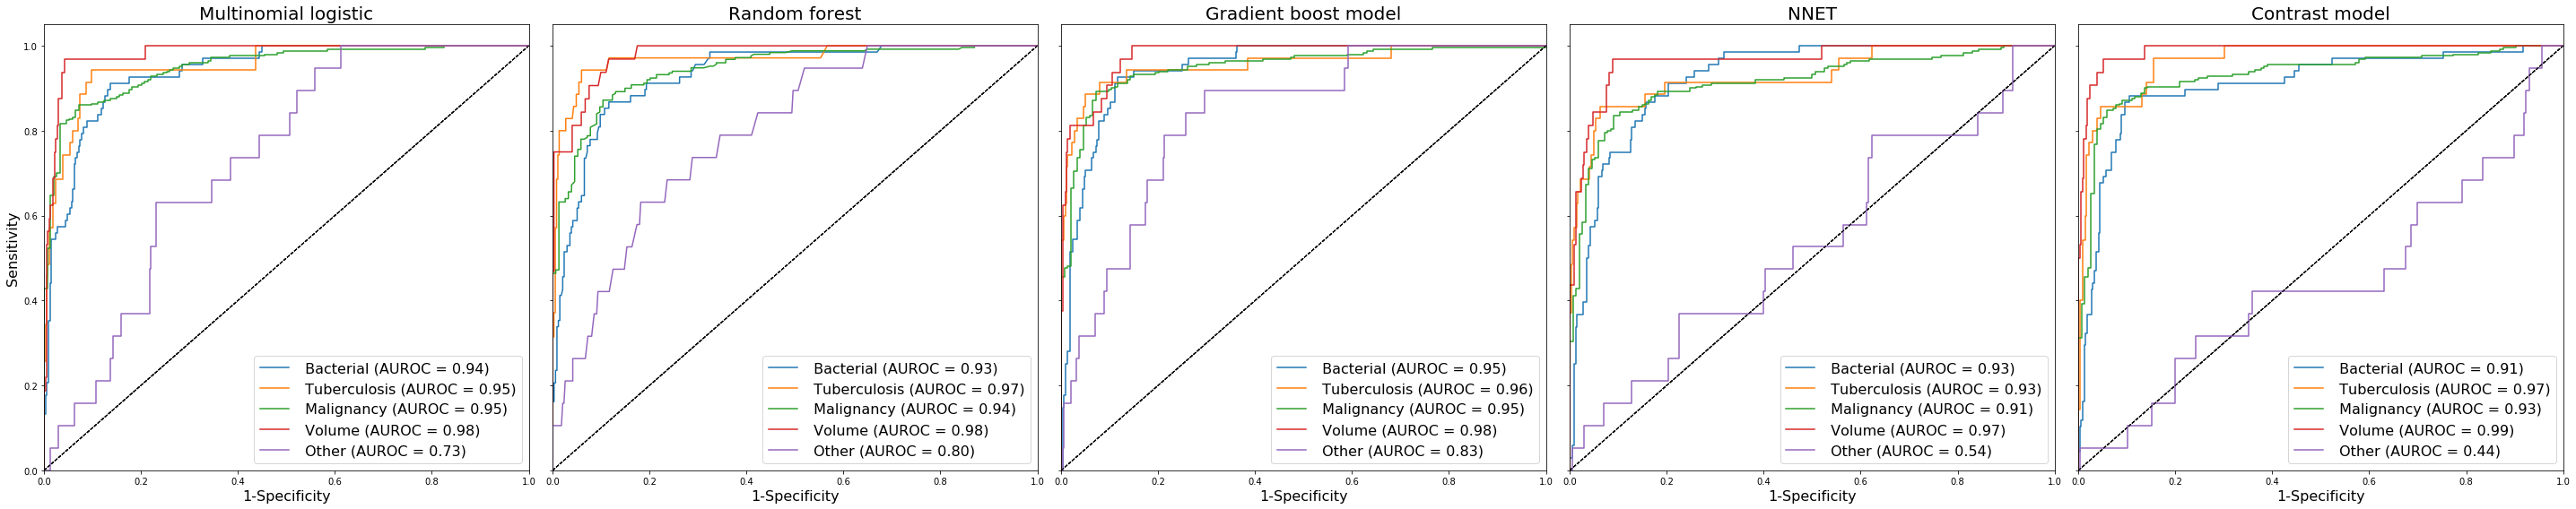

In [43]:
fig, ax = plt.subplots(1,5,figsize=(40,8), sharey=True)
lw=1
for idx, name in enumerate(namelist):
    for i in range(one_y.shape[1]):
        ax[idx].plot(fpr[f"{name}{i}"], tpr[f"{name}{i}"],
#              lw=lw,
             label=' {0} (AUROC = {1:0.2f})'
             ''.format(label_name[i], roc_auc[f"{name}{i}"]))


        ax[idx].plot([0, 1], [0, 1], 'k--', lw=lw)
        ax[idx].set_xlim([0.0, 1.0])
        ax[idx].set_ylim([0.0, 1.05])
        ax[idx].legend(loc="lower right", fontsize=16)
        ax[idx].set_title(modelname[idx], size= 20)
        ax[idx].set_xlabel('1-Specificity', fontsize= 16)
ax[0].set_ylabel('Sensitivity',fontsize= 16)
#ax.set_xlabel('1-specificity', fontsize= 13)
#ax.set_ylabel('Sensitivity', fontsize= 13)
fig.tight_layout()
#fig.suptitle('AUROC in validation set', fontsize= 14)
#ax.legend(loc="lower right", fontsize=12)
plt.show()
fig.savefig("./figures/val_roc_5model300.png", dpi=400)


In [44]:
fpr_eval = dict()
tpr_eval = dict()
roc_auc_eval = dict()
for i in range(one_y_val.shape[1]):
    fpr_eval[f"mn{i}"], tpr_eval[f"mn{i}"], _ = roc_curve(one_y_val[:,i], mn_proba_extra[:,i])
    roc_auc_eval[f"mn{i}"] = auc(fpr_eval[f"mn{i}"], tpr_eval[f"mn{i}"])
for i in range(one_y_val.shape[1]):
    fpr_eval[f"rf{i}"], tpr_eval[f"rf{i}"], _ = roc_curve(one_y_val[:,i], rf_proba_extra[:,i])
    roc_auc_eval[f"rf{i}"] = auc(fpr_eval[f"rf{i}"], tpr_eval[f"rf{i}"])
for i in range(one_y_val.shape[1]):
    fpr_eval[f"gb{i}"], tpr_eval[f"gb{i}"], _ = roc_curve(one_y_val[:,i], lgbm_proba_extra[:,i])
    roc_auc_eval[f"gb{i}"] = auc(fpr_eval[f"gb{i}"], tpr_eval[f"gb{i}"])
for i in range(one_y_val.shape[1]):
    fpr_eval[f"nn{i}"], tpr_eval[f"nn{i}"], _ = roc_curve(one_y_val[:,i], eval_nnet_label.cpu().detach().numpy()[:,i])
    roc_auc_eval[f"nn{i}"] = auc(fpr_eval[f"nn{i}"], tpr_eval[f"nn{i}"])
for i in range(one_y_val.shape[1]):
    fpr_eval[f"sup{i}"], tpr_eval[f"sup{i}"], _ = roc_curve(one_y_val[:,i], eval_sup_label.cpu().detach().numpy()[:,i])
    roc_auc_eval[f"sup{i}"] = auc(fpr_eval[f"sup{i}"], tpr_eval[f"sup{i}"])


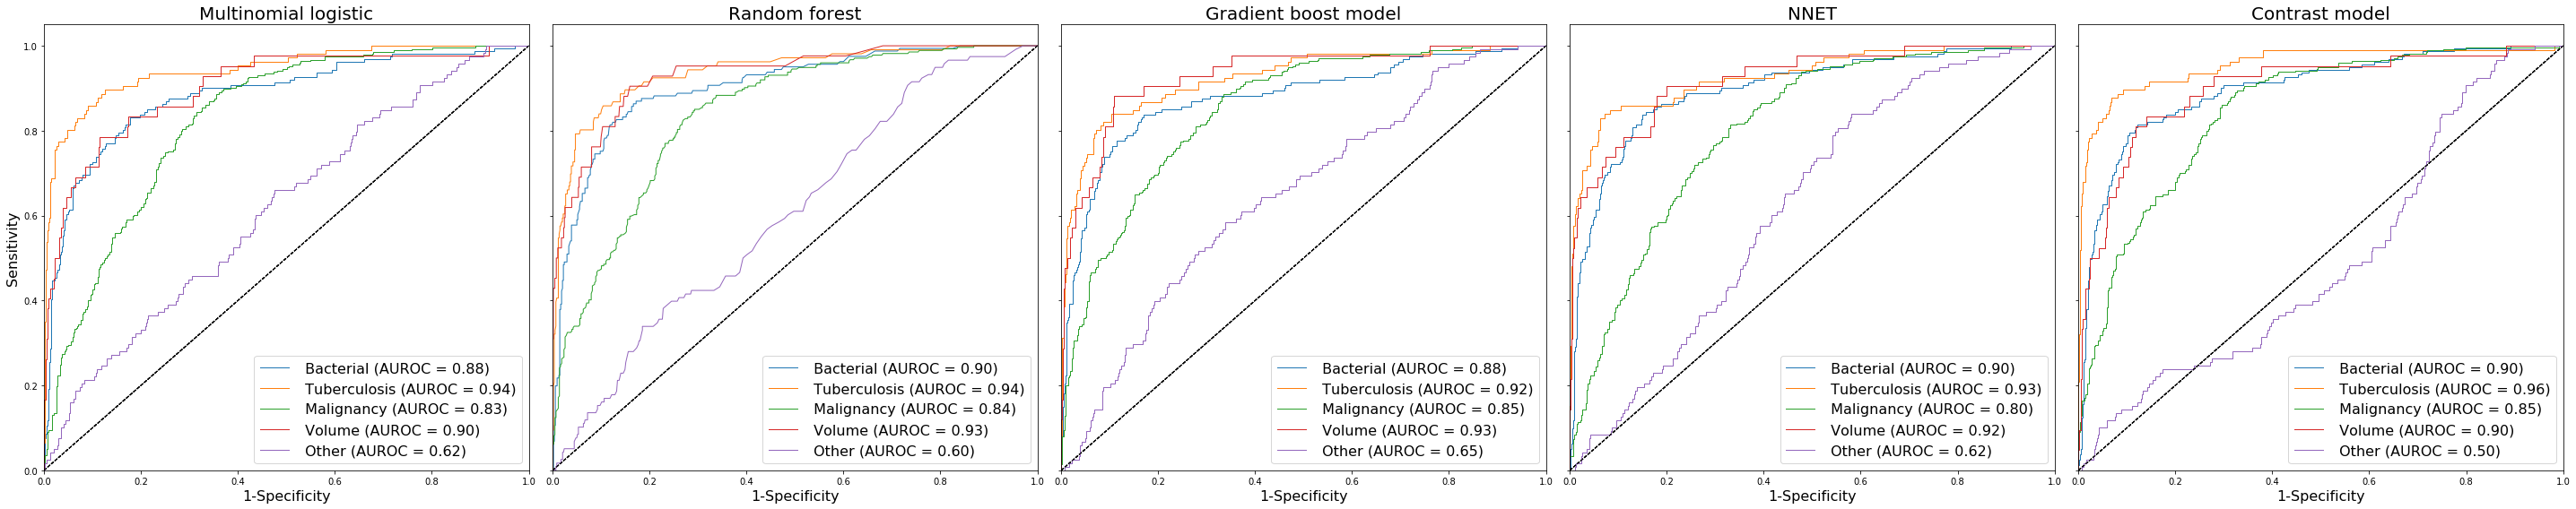

In [45]:
fig, ax = plt.subplots(1,5,figsize=(40,8), sharey=True)
for idx, name in enumerate(namelist):
    for i in range(one_y_val.shape[1]):
        ax[idx].plot(fpr_eval[f"{name}{i}"], tpr_eval[f"{name}{i}"],
             lw=lw,
             label=' {0} (AUROC = {1:0.2f})'
             ''.format(label_name[i], roc_auc_eval[f"{name}{i}"]))


        ax[idx].plot([0, 1], [0, 1], 'k--', lw=lw)
        ax[idx].set_xlim([0.0, 1.0])
        ax[idx].set_ylim([0.0, 1.05])
        ax[idx].legend(loc="lower right", fontsize=16)
        ax[idx].set_title(modelname[idx], size= 20)
        ax[idx].set_xlabel('1-Specificity', fontsize= 16)
ax[0].set_ylabel('Sensitivity',fontsize= 16)
fig.tight_layout()
plt.show()
fig.savefig("./figures/extra_roc_5model300.png", dpi=400)


In [46]:

sup_predict = torch.argmax(eval_sup_label, axis=1)

In [47]:
# confusion_matrix(y_train, predict.cpu()),
print(confusion_matrix(torch.tensor(extra_y.values), sup_predict.cpu()))
print(accuracy_score(torch.tensor(extra_y.values), sup_predict.cpu()))

#classification report
print(classification_report(torch.tensor(extra_y.values), sup_predict.cpu()))

[[110   8  41   2   0]
 [  8  89   9   0   0]
 [  8  13 246   7   0]
 [  5   0  18  19   0]
 [ 18  14  82   4   0]]
0.6619115549215406
              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71       161
         1.0       0.72      0.84      0.77       106
         2.0       0.62      0.90      0.73       274
         3.0       0.59      0.45      0.51        42
         4.0       0.00      0.00      0.00       118

    accuracy                           0.66       701
   macro avg       0.53      0.57      0.55       701
weighted avg       0.56      0.66      0.60       701

